###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2019 Daniel Koehn based on (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 1D Linear Advection Problem: Stability and CFL condition

In the first lesson of this lecture, we studied the numerical solution of the linear and non-linear advection equations, using the finite-difference method. Did you experiment there using different parameter choices? If you did, you probably ran into some unexpected behavior. Did your solution ever blow up (sometimes in a cool way!)? 

In this Jupyter Notebook, we will explore why changing the discretization parameters can affect your solution in such a drastic way.

With the solution parameters we initially suggested, the spatial grid had 41 points and the time-step size was 0.25.  Now, we're going to experiment with the number of points in the grid.  The code below corresponds to the linear advection case, but written into a function so that we can easily examine what happens as we adjust just one variable: **the grid size**.

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
def linear_advection(nx, L=2.0, c=1.0, dt=0.025, nt=20):
    """
    Solves the 1D linear convection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        advection speed; default: 1.0.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        #u[1:] = u[1:] - c * dt / dx * (u[1:] - u[:-1])
        un = u.copy()
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
            
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

Now let's examine the results of the linear advection problem with an increasingly fine mesh.  We'll try 41, 61 and 71 points ... then we'll shoot for 85. See what happens:

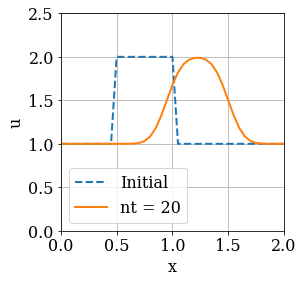

In [5]:
linear_advection(41)  # solve using 41 spatial grid points

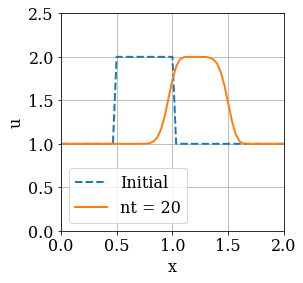

In [6]:
linear_advection(61)

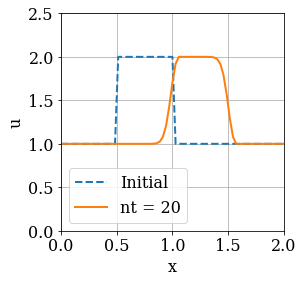

In [7]:
linear_advection(71)

So far so good—as we refine the spatial grid, the wave is more square, indicating that the discretization error is getting smaller. But what happens when we refine the grid even further? Let's try 85 grid points.

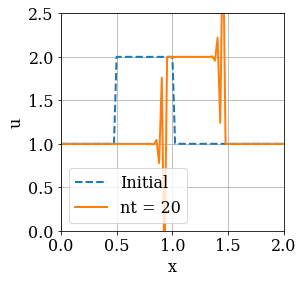

In [8]:
linear_advection(85)

Oops. This doesn't look anything like our original hat function. Something has gone awry. It's the same code that we ran each time, so it's not a bug!

### What happened?

To answer that question, we have to think a little bit about what we're actually implementing in the code when we solve the linear convection equation with the forward-time/backward-space method.  

In each iteration of the time loop, we use the existing data about the solution at time $n$ to compute the solution in the subsequent time step, $n+1$.  In the first few cases, the increase in the number of grid points returned more accurate results.  There was less discretization error and the translating wave looked more like a square wave than it did in our first example.  

Each iteration of the time loop advances the solution by a time-step of length $\Delta t$, which had the value 0.025 in the examples above. During this iteration, we evaluate the solution $u$ at each of the $x_i$ points on the grid.  But in the last plot, something has clearly gone wrong.  

What has happened is that over the time period $\Delta t$, the wave is travelling a distance which is greater than `dx`, and we say that the solution becomes *unstable* in this situation (this statement can be proven formally, see below).  The length `dx` of grid spacing is inversely proportional to the number of total points `nx`: we asked for more grid points, so `dx` got smaller. Once `dx` got smaller than the $c\Delta t$—the distance travelled by the numerical solution in one time step—it's no longer possible for the numerical scheme to solve the equation correctly!

![CFLcondition](figures/CFLcondition.png)
#### Graphical interpretation of the CFL condition.

Consider the illustration above. The green triangle represents the _domain of dependence_ of the numerical scheme. Indeed, for each time step, the variable $u_i^{n+1}$ only depends on the values $u_i^{n}$ and $u_{i-1}^{n}$. 

When the distance $c\Delta t$ is smaller than $\Delta x$, the characteristic line traced from the grid coordinate $i, n+1$ lands _between_ the points $i-1,n$ and $i,n$ on the grid. We then say that the _mathematical domain of dependence_ of the solution of the original PDE is contained in the _domain of dependence_ of the numerical scheme. 

On the contrary, if $\Delta x$ is smaller than $c\Delta t$, then the information about the solution needed for $u_i^{n+1}$ is not available in the _domain of dependence_ of the numerical scheme, because the characteristic line traced from the grid coordinate $i, n+1$ lands _behind_ the point $i-1,n$ on the grid. 

The following condition thus ensures that the domain of dependence of the differential equation is contained in the _numerical_ domain of dependence: 

$$
\begin{equation}
\sigma = \frac{c \Delta t}{\Delta x} \leq 1
\end{equation}
$$

As can be proven formally, for example using the [von Neumann analysis](https://de.wikipedia.org/wiki/Von-Neumann-Stabilit%C3%A4tsanalyse), stability of the numerical solution requires that step size `dt` is calculated with respect to the size of `dx` to satisfy the condition above.  

The value of $c\Delta t/\Delta x$ is called the [**Courant-Friedrichs-Lewy number**](https://gdz.sub.uni-goettingen.de/id/PPN235181684_0100?tify={%22pages%22:[36],%22panX%22:0.519,%22panY%22:0.646,%22view%22:%22info%22,%22zoom%22:0.44}) (CFL number), often denoted by $\sigma$. The value $\sigma_{\text{max}}$ that will ensure stability depends on the discretization used; for the forward-time/backward-space scheme, the condition for stability is $\sigma<1$.

In a new version of our code—written _defensively_—, we'll use the CFL number to calculate the appropriate time-step `dt` depending on the size of `dx`. Furthermore, we also define a maximum modelling time `Tmax`

In [9]:
def linear_advection_cfl(nx, Tmax, L=2.0, c=1.0, sigma=0.5):
    """
    Solves the 1D linear advection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    Tmax : float
        Maximum integration time
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Advection speed; default: 1.0.
    sigma : float, optional
        CFL constraint; default: 0.5.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Compute the time-step size based on the CFL constraint.
    dt = sigma * dx / c
    
    # Compute number of time steps based on Tmax and dt
    nt = (int)(Tmax/dt)
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.legend()
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

Now, it doesn't matter how many points we use for the spatial grid: the solution will always be stable!

In [10]:
# Define maximum time Tmax
Tmax = 0.5

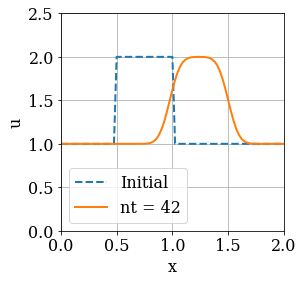

In [11]:
linear_advection_cfl(85,Tmax)

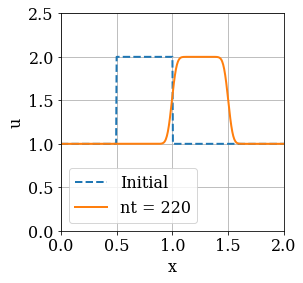

In [12]:
linear_advection_cfl(441,Tmax)

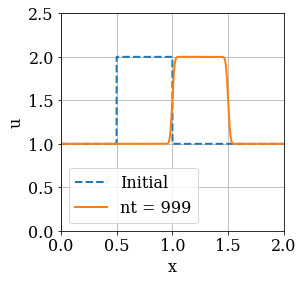

In [13]:
linear_advection_cfl(2000,Tmax)

Notice that as the number of points `nx` increases, the solution of the linear advection problem becomes more accurate at the cost that more time steps `nt` are required resulting in a longer computation time.

## What we learned:

- The numerical solution of 1D linear advection equation becomes unstable, if we choose a time step $\Delta t$ violating the Courant-Friedrichs-Lewy (CFL) criterion:

\begin{equation}
\Delta t \le \frac{\sigma \Delta x}{c} \notag
\end{equation}

depending on the spatial gridpoint distance $\Delta x$, advection velocity $c$ and a factor $\sigma$

- The factor $\sigma$ depends on the used FD-scheme used to solve the 1D linear advection problem or any PDE in general